# CutMix 또는 Mixup 비교실험 하기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## Step 1. Augmentation을 적용한 데이터셋 만들기
### 데이터셋 불러오기

In [2]:
# stanford_dogs 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


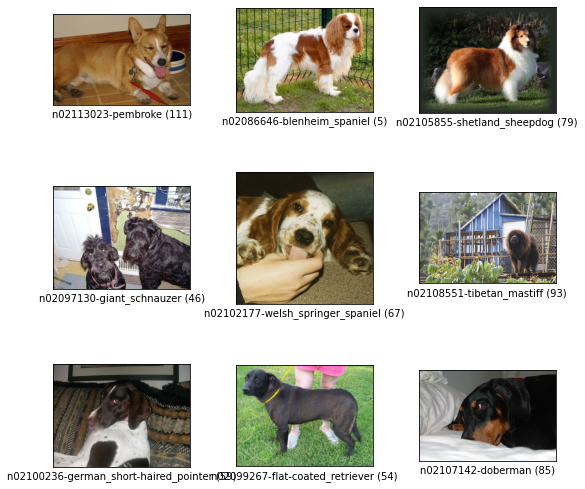

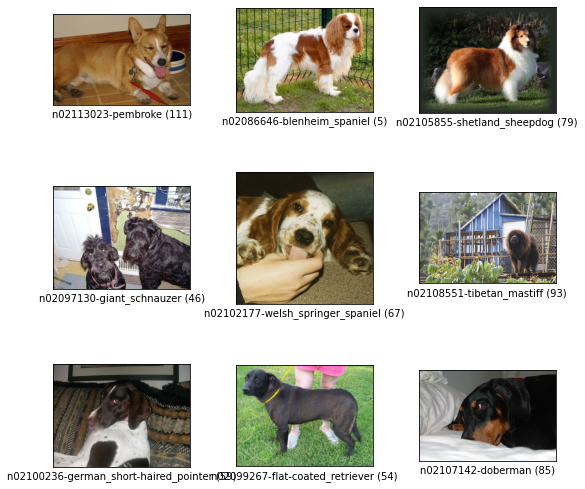

In [3]:
# 다운로드 한 데이터 확인
tfds.show_examples(ds_train, ds_info)

### augmentation에 필요한 함수 만들기

In [4]:
# 기본적인 전처리 함수 만들기
# 정규화 및 resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # (224, 224) 사이즈로 resize
    image = tf.cast(image, tf.float32) / 255. # 0~1 사이의 float32로 normalize
    return image, label

# 기본 augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우대칭
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# 원-핫 labeling
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [5]:
# cutmix augmentation 함수

# 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주기 위해
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 만들기
# width, height가 다르더라도 가변적으로 적용할 수 있도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


# mix two images(바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합침)
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


# mix two labels(섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수)
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


# 배치 단위의 cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [6]:
# # cutmix augmentation 함수
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


# 배치 단위의 mixup 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [7]:
# 데이터셋(ds)을 가공하는 메인 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    
    # 기본 augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # cutmix augmentation
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup augmentation    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### Augmentation 적용하기

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

# augmentation이 적용하지 않음
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
# 기본 augmentation
ds_train_basic_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

# cutmix augmentation
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True, with_mixup=False)
# mixup augmentation
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=True)
# test set
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

- 처음 데이터를 불러올 때, as_supervised=True를 빼고 불러왔는데 TypeError: tf__normalize_and_resize_img() missing 1 required positional argument: 'label'가 계속 발생했다. 다행히 비슷한 문제를 겪은 사람이 stack overflow에 글을 작성해서 해결할 수 있었다. [관련링크](https://stackoverflow.com/questions/70400987/typeerror-tf-normalize-img-missing-1-required-positional-argument-label)  
- 그 외에도 num_classes나 image_a등 정의하지 않아서 발생하는 error들이 있었고, 그걸 충족시키기 위해 하다보니 뭔가 코드가 복잡해진 거 같다.

In [21]:
# 기본 + cutmix augmentation
ds_train_basic_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
# 기본 + mixup augmentation
ds_train_basic_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

## Step 2. 모델 만들기

In [9]:
# ResNet50 : imagenet으로 훈련된 모델 불러오기
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [10]:
# basic augmentation을 위한 ResNet50
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
# cutmix augmentation을 위한 ResNet50
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
# mixup augmentation을 위한 ResNet50
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

- 어차피 resnet50 구조가 모두 동일한데 왜 여러 개를 만들어서 학습을 시키는 건지 의문이 생겼다. 이에 대해 정확한 정보를 찾을 수는 없었지만 고민해 본 결과 augmentation이 적용되지 않은 데이터셋을 학습시키기 위해 사용된 resnet50을 augmentation이 적용된 데이터셋을 학습시키기 위해 다시 사용한다면 제대로 학습효과가 나오지 않기 때문이 아닐까 라는 생각이 들었다. 이 부분에 대해 확신을 못하고 있기 때문에 좀 더 찾아보고 물어봐서 해결하도록 해야겠다.

In [22]:
# 기본 + cutmix을 위한 ResNet50
basic_cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
# 기본 + mixup augmentation을 위한 ResNet50
basic_mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## Step 3. 모델 훈련하기

In [13]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

# no augmentation
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 188s 200ms/step - loss: 2.2153 - accuracy: 0.4487 - val_loss: 3.3506 - val_accuracy: 0.2015
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.7285 - accuracy: 0.7990 - val_loss: 1.1664 - val_accuracy: 0.6569
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2174 - accuracy: 0.9574 - val_loss: 1.0074 - val_accuracy: 0.7053
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0664 - accuracy: 0.9937 - val_loss: 0.8968 - val_accuracy: 0.7403
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0291 - accuracy: 0.9985 - val_loss: 0.8967 - val_accuracy: 0.7449
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0185 - accuracy: 0.9993 - val_loss: 0.9112 - val_accuracy: 0.7432
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.9305 -

In [14]:
# basic augmentation
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_basic_aug = basic_aug_resnet50.fit(
    ds_train_basic_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 2.2906 - accuracy: 0.4318 - val_loss: 3.1030 - val_accuracy: 0.2462
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.9473 - accuracy: 0.7298 - val_loss: 1.3275 - val_accuracy: 0.6255
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.5210 - accuracy: 0.8581 - val_loss: 1.1065 - val_accuracy: 0.6825
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2667 - accuracy: 0.9361 - val_loss: 1.1456 - val_accuracy: 0.6805
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1500 - accuracy: 0.9701 - val_loss: 1.0505 - val_accuracy: 0.7076
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0905 - accuracy: 0.9851 - val_loss: 1.0874 - val_accuracy: 0.7015
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0496 - accuracy: 0.9941 - val_loss: 1.0293 -

In [15]:
# cutmix augmentation
cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix_aug = cutmix_aug_resnet50.fit(
    ds_train_cutmix_aug, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.8082 - accuracy: 0.2189 - val_loss: 3.2456 - val_accuracy: 0.2424
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9256 - accuracy: 0.4379 - val_loss: 1.4612 - val_accuracy: 0.6003
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.6406 - accuracy: 0.5298 - val_loss: 1.2136 - val_accuracy: 0.6604
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4525 - accuracy: 0.5905 - val_loss: 1.2859 - val_accuracy: 0.6496
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2907 - accuracy: 0.6421 - val_loss: 1.1464 - val_accuracy: 0.6874
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1426 - accuracy: 0.6888 - val_loss: 1.3119 - val_accuracy: 0.6556
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0414 - accuracy: 0.7190 - val_loss: 1.3347 -

In [16]:
# mixup augmentation
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup_aug = mixup_aug_resnet50.fit(
    ds_train_mixup_aug, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 3.7135 - accuracy: 0.2396 - val_loss: 3.9404 - val_accuracy: 0.1170
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 2.8739 - accuracy: 0.4778 - val_loss: 1.5322 - val_accuracy: 0.5683
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5933 - accuracy: 0.5785 - val_loss: 1.3951 - val_accuracy: 0.6170
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4123 - accuracy: 0.6550 - val_loss: 1.2627 - val_accuracy: 0.6453
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2416 - accuracy: 0.7069 - val_loss: 1.2830 - val_accuracy: 0.6531
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1312 - accuracy: 0.7527 - val_loss: 1.2245 - val_accuracy: 0.6662
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0727 - accuracy: 0.7741 - val_loss: 1.3081 -

In [24]:
# basic+cutmix augmentation
basic_cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_basic_cutmix_aug = basic_cutmix_aug_resnet50.fit(
    ds_train_basic_cutmix_aug, # basic+cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 157s 199ms/step - loss: 3.8851 - accuracy: 0.1957 - val_loss: 3.0053 - val_accuracy: 0.2711
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 3.0376 - accuracy: 0.4017 - val_loss: 1.2896 - val_accuracy: 0.6365
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.7731 - accuracy: 0.4890 - val_loss: 1.4141 - val_accuracy: 0.6172
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.5787 - accuracy: 0.5488 - val_loss: 1.2177 - val_accuracy: 0.6592
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4552 - accuracy: 0.5853 - val_loss: 1.2419 - val_accuracy: 0.6579
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3678 - accuracy: 0.6124 - val_loss: 1.3286 - val_accuracy: 0.6476
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2663 - accuracy: 0.6386 - val_loss: 1.2813 -

In [25]:
# basic+mixup augmentation
basic_mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_basic_mixup_aug = basic_mixup_aug_resnet50.fit(
    ds_train_basic_mixup_aug, # basic+mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 206ms/step - loss: 3.7989 - accuracy: 0.2192 - val_loss: 3.8229 - val_accuracy: 0.1346
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9506 - accuracy: 0.4483 - val_loss: 1.4232 - val_accuracy: 0.5955
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.6889 - accuracy: 0.5337 - val_loss: 1.4532 - val_accuracy: 0.6019
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5195 - accuracy: 0.5985 - val_loss: 1.3018 - val_accuracy: 0.6336
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3967 - accuracy: 0.6463 - val_loss: 1.5278 - val_accuracy: 0.5883
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3098 - accuracy: 0.6830 - val_loss: 1.2120 - val_accuracy: 0.6611
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2071 - accuracy: 0.7157 - val_loss: 1.2973 -

## Step 4. 훈련 과정 시각화하기

### val_accuracy 비교

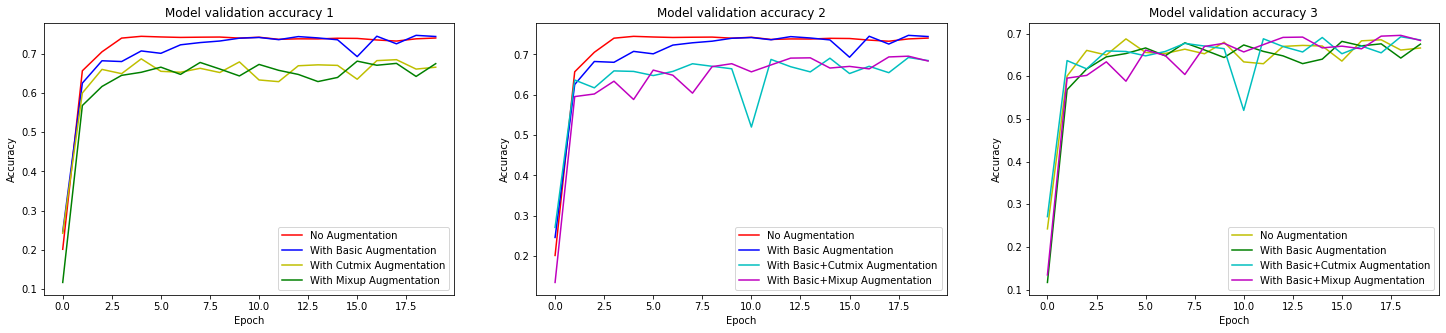

In [37]:
fig=plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='lower right')

plt.subplot(1,3,2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_accuracy'], 'm')
plt.title('Model validation accuracy 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='lower right')

plt.subplot(1,3,3)
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_accuracy'], 'm')
plt.title('Model validation accuracy 3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='lower right')

plt.show()

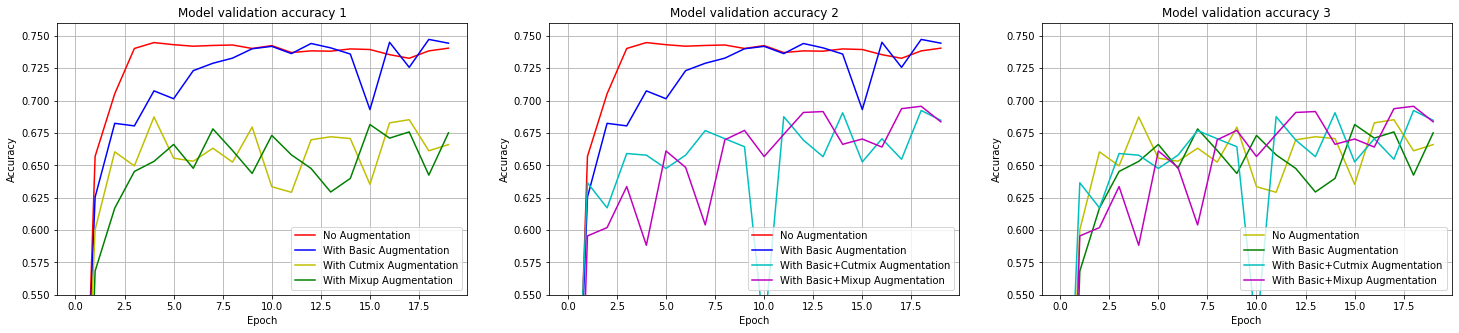

In [40]:
# 확대
fig=plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.76)

plt.subplot(1,3,2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_accuracy'], 'm')
plt.title('Model validation accuracy 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.76)

plt.subplot(1,3,3)
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_accuracy'], 'm')
plt.title('Model validation accuracy 3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.76)

plt.show()

### val_loss 비교

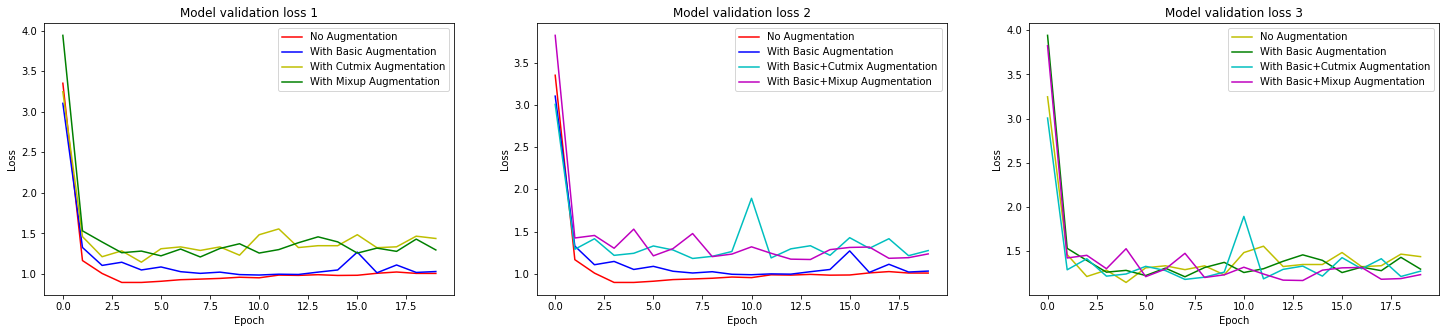

In [42]:
fig=plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_loss'], 'g')
plt.title('Model validation loss 1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_loss'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_loss'], 'm')
plt.title('Model validation loss 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='upper right')

plt.subplot(1,3,3)
plt.plot(history_resnet50_cutmix_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_loss'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_loss'], 'm')
plt.title('Model validation loss 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='upper right')

plt.show()

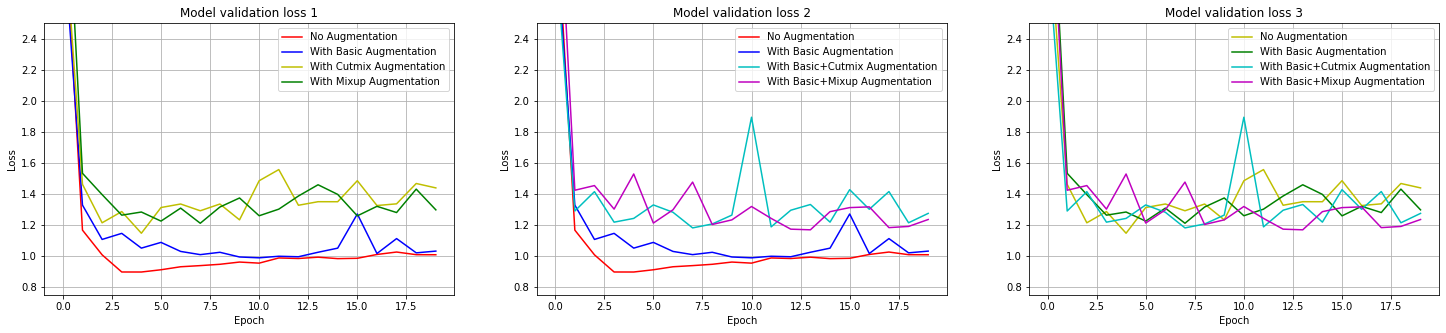

In [45]:
# 확대
fig=plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_loss'], 'g')
plt.title('Model validation loss 1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='upper right')
plt.grid(True)
plt.ylim(0.75, 2.5)

plt.subplot(1,3,2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_basic_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_loss'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_loss'], 'm')
plt.title('Model validation loss 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='upper right')
plt.grid(True)
plt.ylim(0.75, 2.5)

plt.subplot(1,3,3)
plt.plot(history_resnet50_cutmix_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_basic_cutmix_aug.history['val_loss'], 'c')
plt.plot(history_resnet50_basic_mixup_aug.history['val_loss'], 'm')
plt.title('Model validation loss 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Basic+Cutmix Augmentation', 'With Basic+Mixup Augmentation'], loc='upper right')
plt.grid(True)
plt.ylim(0.75, 2.5)

plt.show()

## Step 5. Augmentation에 의한 모델 성능 비교

### val_accuracy 기준

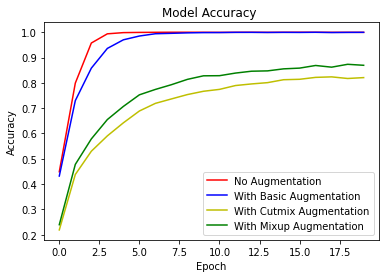

In [51]:
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_basic_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['accuracy'], 'y')
plt.plot(history_resnet50_mixup_aug.history['accuracy'], 'g')
plt.title('Model Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='lower right')

- validation accuracy(이하 val_acc)를 기준으로 봤을 때, augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우가 cutmix, mixup augmentation을 적용한 경우보다 더 높았다. 그 이유는 train set accuracy를 보면 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우가 cutmix, mixup augmentation을 적용한 경우보다 더 높은 것을 봤을 때 노이즈가 더 심한 데이터로 20 epoch으로 학습시키기에는 epoch 수가 부족해 학습이 제대로 안되었기 때문이라고 생각한다. 정확한 건 epoch 수를 늘려보고 결과를 보아야 알 수 있지만 20 epoch인 상태에서는 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우가 cutmix, mixup augmentation을 적용한 경우보다 성능이 더 좋다. cutmix augmentation과 mixup augmentation 간에 성능 비교는 유의미할 정도의 차이가 보이지 않아 두 augmentation 간의 비교는 생략하도록 하겠다.  
- 기본 augmentation을 적용한 경우 상대적으로 val_acc가 높은 편이어서 기본 augmentation에 cutmix, mixup augmentation을 섞은 상태로 val_acc를 비교해보았다. 기본 augmentation에 cutmix, mixup augmentation을 섞어도 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우보다는 val_acc가 낮은 편이었지만 기본 augmentation을 섞지 않은 cutmix, mixup augmentation과 비교해봤을 때, 초반에는 기본 augmentation을 섞지 않은 cutmix, mixup augmentation의 val_acc가 더 높은 듯 했지만 뒤로 갈수록 기본 augmentation을 섞은 cutmix, mixup augmentation의 val_acc가 높아졌다. 물론 epoch이 20밖에 되지 않아 epoch을 늘렸을 때 결과가 어떻게 나올지는 모르겠지만 기본 augmentation을 섞지 않은 경우보다는 섞은 경우의 성능이 더 좋은 것으로 판단되었다.  
- 결론 : 20 epoch 기준으로 할 때, augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우, 기본 augmentation을 섞은 cutmix & mixup augmentation, 기본 augmentation을 섞지 않은 cutmix & mixup augmentation 순으로 성능이 좋았다.

### val_loss 기준

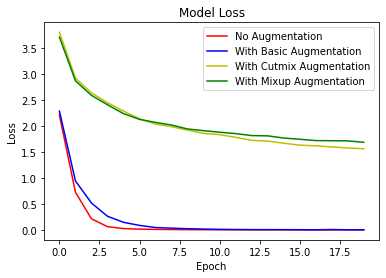

In [52]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_basic_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['loss'], 'y')
plt.plot(history_resnet50_mixup_aug.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With Cutmix Augmentation', 'With Mixup Augmentation'], loc='upper right')

- validation loss(이하 val_loss)를 기준으로 봤을 때, val_acc와 크게 다를 것이 없었다. loss 값이 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우가 cutmix, mixup augmentation을 적용한 경우보다 더 낮았다. 그 이유는 val_acc와 동일할 것이라고 생각한다. 따라서 val_acc와 마찬가지로 20 epoch인 상태에서는 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우가 cutmix, mixup augmentation을 적용한 경우보다 성능이 더 좋다. 그래도 val_acc에 비해면 val_loss는 아주 큰 차이가 나는 건 아니었다.  
- 기본 augmentation을 적용한 경우 상대적으로 val_loss가 꽤 낮은 편이어서 기본 augmentation에 cutmix, mixup augmentation을 섞은 상태로 val_loss를 비교해보았다. 이 역시도 val_acc의 결과랑 크게 다를 바 없었다. 기본 augmentation에 cutmix, mixup augmentation을 섞어도 augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우보다는 val_loss가 높은 편이었지만 기본 augmentation을 섞지 않은 cutmix, mixup augmentation과 비교해봤을 때, 초반에는 기본 augmentation을 섞지 않은 cutmix, mixup augmentation의 val_loss와 섞은 val_loss가 비슷해보였는데 점점 기본 augmentation을 섞은 cutmix, mixup augmentation의 val_loss가 낮아졌다. loss값을 통해서도 기본 augmentation을 섞지 않은 경우보다는 섞은 경우의 성능이 더 좋은 것으로 판단되었다.  
- 결론 : val_acc와 마찬가지로 20 epoch 기준으로 할 때, augmentation을 적용하지 않은 경우와 기본 augmentation을 적용한 경우, 기본 augmentation을 섞은 mixup augmentation, 기본 augmentation을 섞은 cutmix augmentation, 기본 augmentation을 섞지 않은 cutmix & mixup augmentation 순으로 성능이 좋았다.

-----------

## 회고
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
비록 augmentation을 적용하지 않은 데이터셋과 기본 augmentation을 적용한 데이터셋에 비해 val_accuracy도 val_loss도 결과가 좋지는 못했지만 CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴해가는 것을 그래프 시각화를 통해 확인할 수 있었다.  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
augmentation을 적용하지 않아도 보고, 기본 augmentation만 적용해보기도 하고, 일반 mixup과 cutmix도 해보고, mixup과 cutmix에 기본 augmentation을 섞어도 봤는데, 20 epoch 기준으로 했을 때에는 오히려 augmentation을 적용하지 않거나 기본 augmentation만 적용한 것이 성능이 더 좋았다. 이 둘을 배제하고 본다면 20 epoch 기준으로 val_acc는 가장 높아지고 val_loss는 가장 낮아졌으며 계속해서 수렴을 잘하는 추세를 보인 기본 augmentation을 섞은 mixup augmentation이라고 본다.  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 그래프로 시각화하여 비교해보았고, 그 결과를 분석하며 성능비교를 해보았다.  
4. 프로젝트를 진행하면서 느낀 점: 학습하는데 시간이 다소 오래 걸리기는 했지만 하면서도 이렇게 해볼까 저렇게 해볼까 생각이 드는 프로젝트였다. 시간적으로 제한이 있기 때문에 더 다양하게 augmentation을 해보지 못하고 더 다양하게 비교해보지 못해서 아쉽기는 하지만 프로젝트를 통해 또 많이 배워간다는 느낌이 들어 뿌듯하다.  

## Reference
- [TypeError 해결법](https://stackoverflow.com/questions/70400987/typeerror-tf-normalize-img-missing-1-required-positional-argument-label)  